# Credit Card Fraud Detection
- [notice] imbalanced dataset
- Amount feature `log transformation` & `outlier제거` & `SMOTE oversampling`을 진행 후, `LightGBM` 학습/예측한 결과가 가장 좋은 결과를 도출했다.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.getcwd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


<function posix.getcwd()>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

def get_preprocessed_df(df=None): #필요없는 열 제거
    df_copy= df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

def get_train_test_dataset(df=None) : # data split
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_labels = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, stratify=y_labels)
    return X_train, X_test, y_train, y_test 

def get_clf_eval(y_test, preds, pred_probs): # print evaluation metric
    mat = confusion_matrix(y_test,preds)
    acc = accuracy_score(y_test,preds)
    precision = precision_score(y_test,preds)
    recall = recall_score(y_test,preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test,preds)
    print('오차행렬 \n{}  \n정확도 : {:.6f} 정밀도 :{:.3f} 재현율 :{:.3f} f1 :{:.3f} auc:{:.3f}'.format(mat, acc,precision, recall,f1,auc))

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None): # 학습 / 예측 / 평가
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(y_test=tgt_test,preds=pred,pred_probs=pred_proba)

## 데이터 1차 가공 및 모델 학습/예측/평가
- inbalance data이므로 train_test_split() stratify옵션을 활용해 원본 데이터와 유사하게 train, test dataset으로 분할함

In [3]:
dataset = pd.read_csv('./../input/creditcardfraud/creditcard.csv')
print('dataset shape :', dataset.shape)
dataset.head(3)

dataset shape : (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
X_train, X_test, y_train, y_test = get_train_test_dataset(dataset)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('학습데이터 레이블값 비율{0:.6f}'.format((sum(y_train==1)/y_train.count())*100))
print('테스트데이터 레이블값 비율{0:.6f}'.format((sum(y_test==1)/y_test.count())*100))

(199364, 29) (85443, 29) (199364,) (85443,)
학습데이터 레이블값 비율0.172549
테스트데이터 레이블값 비율0.173215


### LogisticRegression 학습/ 예측/ 평가
- 정확도 : 0.999251 정밀도 :0.882 재현율 :0.655 f1 :0.752 auc:0.828

In [5]:
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차행렬 
[[85279    16]
 [   51    97]]  
정확도 : 0.999216 정밀도 :0.858 재현율 :0.655 f1 :0.743 auc:0.828


### LightGBM 학습/ 예측/ 평가
- imbalanced data 이므로 LGBMClassifier 객체 생성시 Boost_from_average=False로 지정함
- 정확도 : 0.999590 정밀도 :0.938 재현율 :0.818 f1 :0.874 auc:0.909


In [6]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬 
[[85290     5]
 [   22   126]]  
정확도 : 0.999684 정밀도 :0.962 재현율 :0.851 f1 :0.903 auc:0.926


## 데이터 분포 변환 후 모델 학습/예측/평가
- 왜곡된 분포를 가지는 피쳐가 있는지 확인해보자.
- Amount feature의 경우 굉장히 치우쳐있고 대다수의 값들이 1000$ 이하다. 
    *  StandardScaler()를 활용해 scaling을 진행
        * LogisticRegression 예측 성능 : <Br>정확도 : 0.999087 정밀도 :0.850 재현율 :0.574 f1 :0.685 auc:0.787 
        * LightGBM 예측성능 : <Br>정확도 : 0.996980 정밀도 :0.259 재현율 :0.399 f1 :0.314 auc:0.698 
    *  **np.log1p를 활용해 scaling을 진행**
        * LogisticRegression 예측 성능 : <Br>정확도 : 0.999274 정밀도 :0.906 재현율 :0.649 f1 :0.756 auc:0.824
        * LightGBM 예측성능 : <br> 정확도 : 0.997390 정밀도 :0.025 재현율 :0.014 f1 :0.018 auc:0.506        

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

<AxesSubplot:xlabel='Amount', ylabel='Density'>

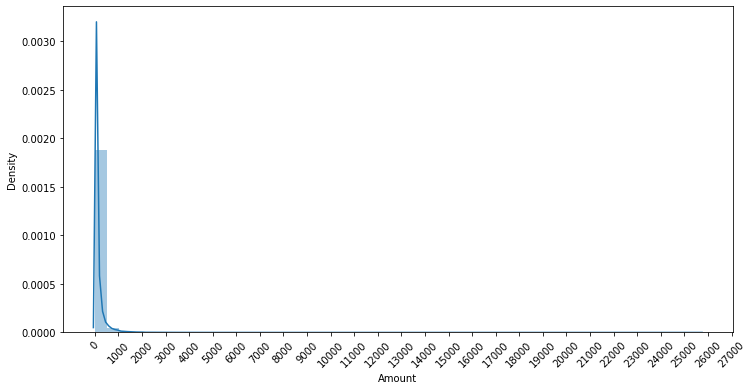

In [8]:
plt.figure(figsize=(12,6))
plt.xticks(range(0,30000,1000),rotation=45)
sns.distplot(dataset['Amount'])

### StandardScaler()를 활용해 scaling을 진행

In [9]:
def get_preprocessed_df(df=None): #필요없는 열 제거
    df_copy= df.copy()
    scaler = StandardScaler()
    amount_scaled = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled',amount_scaled)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

# Amount 분포 변환 후 로지스틱회귀분석, LightGBM 학습/예측/평가 진행
X_train, X_test,y_train,y_test = get_train_test_dataset(dataset)

print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf,X_train, X_test,y_train,y_test)
print('='*50)

print('LightGBM 예측성능')
lr_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,n_jobs=-1)
get_model_train_eval(lr_clf,X_train, X_test,y_train,y_test)
print('='*50)

LogisticRegression 예측 성능
오차행렬 
[[85290     5]
 [   52    96]]  
정확도 : 0.999333 정밀도 :0.950 재현율 :0.649 f1 :0.771 auc:0.824
LightGBM 예측성능
오차행렬 
[[85106   189]
 [  148     0]]  
정확도 : 0.996056 정밀도 :0.000 재현율 :0.000 f1 :0.000 auc:0.499


### np.log1p를 활용해 scaling을 진행

In [10]:
def get_preprocessed_df(df=None): #필요없는 열 제거
    df_copy= df.copy()
    amount_scaled = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_scaled)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

# Amount 분포 변환 후 로지스틱회귀분석, LightGBM 학습/예측/평가 진행
X_train, X_test,y_train,y_test = get_train_test_dataset(dataset)

print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf,X_train, X_test,y_train,y_test)
print('='*50)

print('LightGBM 예측성능')
lr_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,n_jobs=-1)
get_model_train_eval(lr_clf,X_train, X_test,y_train,y_test)
print('='*50)

LogisticRegression 예측 성능
오차행렬 
[[85283    12]
 [   59    89]]  
정확도 : 0.999169 정밀도 :0.881 재현율 :0.601 f1 :0.715 auc:0.801
LightGBM 예측성능
오차행렬 
[[85221    74]
 [   57    91]]  
정확도 : 0.998467 정밀도 :0.552 재현율 :0.615 f1 :0.581 auc:0.807


## 이상치 제거후 모델 학습/예측/평가
- 이상치를 제거하기 전보다 재현률이 크게 증가한것을 확인 할 수 있음

<AxesSubplot:>

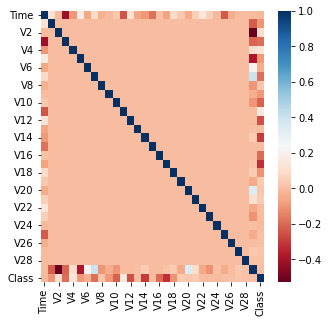

In [11]:
plt.figure(figsize=(5,5))
corr = dataset.corr()
sns.heatmap(corr,cmap='RdBu')

In [12]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    q25 = np.percentile(fraud.values,25)
    q75 = np.percentile(fraud.values,75)
    iqr = q75- q25
    iqr_w = iqr*weight
    low = q25 - iqr_w
    high = q75 + iqr_w
    outlier_index = fraud[(fraud<low) | (fraud > high)].index
    return outlier_index

outlier_index = get_outlier(dataset, column='V14', weight=1.5)
print('이상치 데이터 인덱스 :',outlier_index)

이상치 데이터 인덱스 : Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [13]:
def get_preprocessed_df(df=None): #필요없는 열 제거
    df_copy= df.copy()
    amount_scaled = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_scaled)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index,axis=0,inplace=True)
    return df_copy

# Amount log transformation & outlier제거후 로지스틱회귀분석, LightGBM 학습/예측/평가 진행
X_train, X_test,y_train,y_test = get_train_test_dataset(dataset)

print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf,X_train, X_test,y_train,y_test)
print('='*50)

print('LightGBM 예측성능')
lr_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,n_jobs=-1)
get_model_train_eval(lr_clf,X_train, X_test,y_train,y_test)
print('='*50)

LogisticRegression 예측 성능
오차행렬 
[[85282    13]
 [   63    83]]  
정확도 : 0.999110 정밀도 :0.865 재현율 :0.568 f1 :0.686 auc:0.784
LightGBM 예측성능
오차행렬 
[[85090   205]
 [  146     0]]  
정확도 : 0.995892 정밀도 :0.000 재현율 :0.000 f1 :0.000 auc:0.499


## SMOTE 오버샘플링 적용후 모델 학습/예측/평가
- 오버샘플링을 한 후 학습/예측/평가를 해보자
- SMOTE를 적용할 때는 반드시 학습데이터 세트만 오버샘플링을 해야한다.<br> 검증 데이터나 테스트 데이터 서트를 오버샘플링할경우 올바른 결과라고 할 수 없음
    * LogisticRegression 예측 성능 : <br> 정확도 : 0.971981 정밀도 :0.054 재현율 :0.925 f1 :0.101 auc:0.948 <Br> **로지스틱회귀분석의 경우 정밀도가 매우 낮아서 모델을 적용할수 없다.<Br> 실제 원본보다 매우 많은 Class=1 데이터를 학습하면서 실제 데이터 세트에서 예측을 지나치게 Class=1에 적용해 정밀도가 급격히 떨어지게 되었음**
    * LightGBM 예측성능 : <br> 정확도 : 0.999462 정밀도 :0.852 재현율 :0.829 f1 :0.840 auc:0.914
  

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('smote 적용 전 train dataset shape',X_train.shape, y_train.shape)
print('smote 적용 후 train dataset shape',X_train_over.shape, y_train_over.shape)
print('smote 적용 후 target 분포 :\n', y_train_over.value_counts()); print('='*50)

print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf,X_train_over, X_test,y_train_over,y_test)
print('='*50)

print('LightGBM 예측성능')
lr_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,n_jobs=-1)
get_model_train_eval(lr_clf,X_train_over, X_test,y_train_over,y_test)
print('='*50)


smote 적용 전 train dataset shape (199362, 29) (199362,)
smote 적용 후 train dataset shape (398040, 29) (398040,)
smote 적용 후 target 분포 :
 0    199020
1    199020
Name: Class, dtype: int64
LogisticRegression 예측 성능
오차행렬 
[[83366  1929]
 [   25   121]]  
정확도 : 0.977130 정밀도 :0.059 재현율 :0.829 f1 :0.110 auc:0.903
LightGBM 예측성능
오차행렬 
[[85268    27]
 [   33   113]]  
정확도 : 0.999298 정밀도 :0.807 재현율 :0.774 f1 :0.790 auc:0.887
